In [58]:
from stimulus import stimulus
import static_nda as nda
import datajoint as dj
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Stimulus Design

In [77]:
all_ids = dj.U('image_class','image_id').aggr((stimulus.Trial & nda.Scan)*stimulus.Frame,
                                             n_total='count(*)',
                                             min_animal='MIN(animal_id)',
                                             min_scan = 'MIN(scan_idx)', 
                                             min_session = 'MIN(session)')
all_ids = dj.U('image_id','n_total','min_animal','min_scan','min_session') & all_ids


In [101]:
# dj.U('stimulus_type').aggr(dj.U('stimulus_type','condition_hash') * 
#                            (stimulus.Condition & (stimulus.Trial & nda.Scan)),n='count(*)')

KeyboardInterrupt: 

In [104]:
print('\nall one presentation time: ',
      (dj.U('presentation_time') & (stimulus.Frame & (stimulus.Trial & nda.Scan))).fetch1('presentation_time'),
      ' sec')

/usr/local/lib/python3.6/dist-packages/datajoint/connection.py:219: UserWarning: MySQL server has gone away. Reconnecting to the server.
  warnings.warn("MySQL server has gone away. Reconnecting to the server.")


KeyboardInterrupt: 

In [ ]:
print('\nall one image class: ',
      (dj.U('image_class') & (stimulus.Frame & (stimulus.Trial & nda.Scan))).fetch1('image_class'))

print('\ntotal unique images: ', len(dj.U('image_class','image_id') & \
                                     (stimulus.Frame & (stimulus.Trial & nda.Scan))))

In [59]:
all_hashes = dj.U('condition_hash').aggr(stimulus.Trial & nda.Scan,
                                         n_total='count(*)',
                                         min_animal='MIN(animal_id)',
                                         min_scan = 'MIN(scan_idx)', 
                                         min_session = 'MIN(session)')
all_hashes = dj.U('condition_hash','n_total','min_animal','min_scan','min_session') & all_hashes

display(dj.U('stimulus_type').aggr(stimulus.Condition & all_hashes,n_hashes = 'count(*)'))


print('\nall one presentation time: ',
      (dj.U('presentation_time') & (stimulus.Frame & all_hashes)).fetch1('presentation_time'),
      ' sec')

print('\nall one image class: ',
      (dj.U('image_class') & (stimulus.Frame & all_hashes)).fetch1('image_class'))

print('\ntotal unique images: ', len(dj.U('image_class','image_id') & (stimulus.Frame & all_hashes)))

stimulus_type class name of the special stimulus condition table class,n_hashes calculated attribute
stimulus.Clip,6
stimulus.Frame,35800



all one presentation time:  0.5  sec

all one image class:  imagenet

total unique images:  30200


# Single Scan Composition

In [115]:
repeat_df = []
for scan in nda.Scan.proj():
    scan_str = '_'.join([str(s) for s in scan.values()])
    
    scan_hashes = stimulus.Condition * dj.U('condition_hash').aggr(stimulus.Trial & scan,n_repeats='count(*)')
    hash_repeats = dj.U('stimulus_type','n_repeats').aggr(scan_hashes,n_hashes='count(*)')
    repeat_str = ', '.join([str(d['n_repeats'])+'x '+ 
                            d['stimulus_type'].replace('stimulus.','') + ': ' + 
                            str(d['n_hashes']) 
                            for d in hash_repeats.fetch(as_dict=True)])
    
    repeat_df.append({'scan':scan_str,'repeats':repeat_str})
    
repeat_df = pd.DataFrame(repeat_df)
display(repeat_df.groupby('repeats').count())
display(repeat_df)
    
    

,scan
repeats,
"1x Frame: 5000, 10x Frame: 100",14
"9x Clip: 6, 1x Frame: 5000, 10x Frame: 200",2


,scan,repeats
0,21067_9_17,"1x Frame: 5000, 10x Frame: 100"
1,21067_10_18,"1x Frame: 5000, 10x Frame: 100"
2,21067_13_14,"1x Frame: 5000, 10x Frame: 100"
3,22620_4_15,"1x Frame: 5000, 10x Frame: 100"
4,22620_4_17,"1x Frame: 5000, 10x Frame: 100"
5,22620_5_11,"1x Frame: 5000, 10x Frame: 100"
6,22846_2_19,"1x Frame: 5000, 10x Frame: 100"
7,22846_2_21,"1x Frame: 5000, 10x Frame: 100"
8,22846_7_15,"1x Frame: 5000, 10x Frame: 100"
9,22846_10_16,"1x Frame: 5000, 10x Frame: 100"


# Oracle Frames (10x)

In [ ]:
all_trials = (stimulus.Trial & nda.Scan)

intrascan_rel = dj.U('animal_id','session','scan_idx','image_id').aggr(all_trials*stimulus.Frame,
                                                                       intrascan_repeats='count(*)')
interscan_rel = dj.U('image_id').aggr(intrascan_rel & 'intrascan_repeats=10',interscan_repeats = 'count(*)')
display(dj.U('interscan_repeats').aggr(interscan_rel,scan_count='count(*)'))


print('100 unique image ids are repeated 10x in each of 16 scans')
print('\nan additional 100 unique image ids are repeated 10x in 2 scans')

display(dj.U('image_id','pre_blank_period').aggr((all_trials * stimulus.Frame) & 
                                         (interscan_rel & 'interscan_repeats=16').proj(),n_delays='count(*)'))
print('not all pre_blank periods are unique')

# Unique Frames (1x)

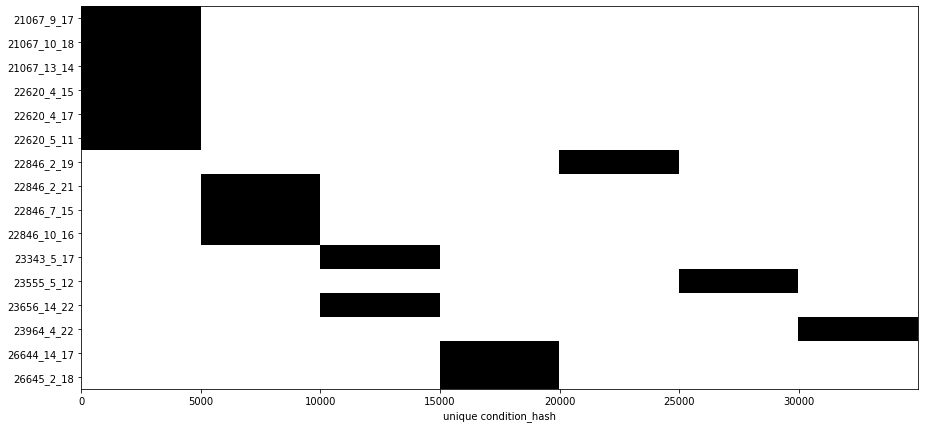

In [132]:
all_1x_hashes = all_hashes & (stimulus.Frame & (intrascan_rel & 'intrascan_repeats = 1').proj())

hash_presence = []
for scan in nda.Scan():
    scan_hashes = (all_1x_hashes.aggr(stimulus.Trial & scan,n_scan = 'count(trial_idx)',
                                   keep_all_rows=True)).fetch('n_scan',
                                   order_by='n_total DESC, min_animal ASC, min_scan ASC, min_session ASC')
    hash_presence.append({'scan_key':scan,'hash_presence':scan_hashes})
    
fig,ax = plt.subplots(figsize=(15,15))
ax.imshow(np.vstack([s['hash_presence'] for s in hash_presence])>0,cmap='binary',interpolation='none')
ax.set_aspect(1000)
ax.set_xlabel('unique condition_hash')
ax.set_yticks(np.arange(len(nda.Scan())))
_ = ax.set_yticklabels(['_'.join([str(s) for s in key.values()]) for key in nda.Scan.proj()])
plt.show()
plt.close()

# repeat_rel = dj.U('image_class','image_id').aggr(stimulus.Frame & (stimulus.Trial & nda.Scan),n='count(*)')
# no_repeat = repeat_rel & 'n=1'
# display(no_repeat)
# two_repeat = repeat_rel & 'n=2'
# display(two_repeat)
# seven_repeat = repeat_rel & 'n=6'
# display(seven_repeat)

# print('scans containing condition_hashes with non_unique images: ')
# display(nda.Scan.proj() & (stimulus.Trial & (stimulus.Frame & two_repeat.proj())))

In [123]:
intrascan_rel

animal_id id number,session session index for the mouse,scan_idx number of TIFF stack file,image_id image id,intrascan_repeats calculated attribute
21067,9,17,0,1
21067,9,17,2,1
21067,9,17,4,1
21067,9,17,5,1
21067,9,17,7,1
21067,9,17,10,1
21067,9,17,13,1
21067,9,17,15,1
21067,9,17,16,1
21067,9,17,17,1


In [ ]:
all_hashes & (stimulus.Fr)

In [122]:
all_hashes

condition_hash 120-bit hash (The first 20 chars of MD5 in base64),n_total calculated attribute,min_animal calculated attribute,min_scan calculated attribute,min_session calculated attribute
++0B7xzlNZVAHyad5+fd,1,23964,22,4
++0nsGPrmM7MZdBkJwSk,6,21067,11,4
++3tQPRBlpY7qJVm3iDP,6,21067,11,4
++5s+P0tel9UE+CJMLpV,1,23964,22,4
++ETlCaOTvZVsIUYqTC7,2,26644,17,2
++FEAZDmvDuQSfyFAnrP,1,23964,22,4
++NpZoKtSf9aIqtOgFqX,1,22846,19,2
++Y/uwHah31/5SgNnMaI,6,21067,11,4
+/2HT1LKAWuxODpfOSo1,1,23964,22,4
+/ahg2Id34P1vOV8dZG9,2,23343,17,5


In [121]:
all_hashes & (intrascan_rel & 'intrascan_repeats = 1') 

/usr/local/lib/python3.6/dist-packages/datajoint/connection.py:219: UserWarning: MySQL server has gone away. Reconnecting to the server.
  warnings.warn("MySQL server has gone away. Reconnecting to the server.")


condition_hash 120-bit hash (The first 20 chars of MD5 in base64),n_total calculated attribute,min_animal calculated attribute,min_scan calculated attribute,min_session calculated attribute
++0B7xzlNZVAHyad5+fd,1,23964,22,4
++0nsGPrmM7MZdBkJwSk,6,21067,11,4
++3tQPRBlpY7qJVm3iDP,6,21067,11,4
++5s+P0tel9UE+CJMLpV,1,23964,22,4
++ETlCaOTvZVsIUYqTC7,2,26644,17,2
++FEAZDmvDuQSfyFAnrP,1,23964,22,4
++NpZoKtSf9aIqtOgFqX,1,22846,19,2
++Y/uwHah31/5SgNnMaI,6,21067,11,4
+/2HT1LKAWuxODpfOSo1,1,23964,22,4
+/ahg2Id34P1vOV8dZG9,2,23343,17,5


In [50]:
stats.Oracle.UnitScores & scan & group_rest

group_id index of group,data_hash unique identifier for configuration,animal_id id number,session session index for the mouse,scan_idx number of TIFF stack file,pipe_version,segmentation_method,spike_method spike inference method,preproc_id preprocessing ID,unit_id unique per scan & segmentation method,pearson mean test correlation,spearman
237,7572eed73113c993e7d1b92f83e270b4,26645,2,18,1,6,5,5,2,0.35089,0.307219
237,7572eed73113c993e7d1b92f83e270b4,26645,2,18,1,6,5,5,3,0.529752,0.370975
237,7572eed73113c993e7d1b92f83e270b4,26645,2,18,1,6,5,5,4,0.636911,0.423175
237,7572eed73113c993e7d1b92f83e270b4,26645,2,18,1,6,5,5,5,0.22498,0.290716
237,7572eed73113c993e7d1b92f83e270b4,26645,2,18,1,6,5,5,6,0.422049,0.386721
237,7572eed73113c993e7d1b92f83e270b4,26645,2,18,1,6,5,5,7,0.279723,0.35144
237,7572eed73113c993e7d1b92f83e270b4,26645,2,18,1,6,5,5,8,0.470597,0.359601
237,7572eed73113c993e7d1b92f83e270b4,26645,2,18,1,6,5,5,9,0.459284,0.322526
237,7572eed73113c993e7d1b92f83e270b4,26645,2,18,1,6,5,5,11,0.376521,0.304924
237,7572eed73113c993e7d1b92f83e270b4,26645,2,18,1,6,5,5,12,0.469469,0.226851


In [86]:
dics = np.load('/mnt/scratch07/zhiwei/static_scan_release_keys_filtered.npy', allow_pickle=True)

{'animal_id': 21067, 'session': 9, 'scan_idx': 17, 'pipe_version': 1, 'group_id': 29, 'segmentation_method': 6, 'spike_method': 5, 'preproc_id': 0, 'stack': '21067-9-1', 'album_id': 2}
{'animal_id': 21067, 'session': 10, 'scan_idx': 18, 'pipe_version': 1, 'group_id': 35, 'segmentation_method': 6, 'spike_method': 5, 'preproc_id': 0, 'stack': '21067-10-25', 'album_id': 2}
{'animal_id': 21067, 'session': 13, 'scan_idx': 14, 'pipe_version': 1, 'group_id': 38, 'segmentation_method': 6, 'spike_method': 5, 'preproc_id': 0, 'stack': '21067-13-2', 'album_id': 2}
{'animal_id': 22620, 'session': 4, 'scan_idx': 15, 'pipe_version': 1, 'group_id': 55, 'segmentation_method': 6, 'spike_method': 5, 'preproc_id': 0, 'stack': '22620-4-16', 'album_id': 2}
{'animal_id': 22620, 'session': 4, 'scan_idx': 17, 'pipe_version': 1, 'group_id': 69, 'segmentation_method': 6, 'spike_method': 5, 'preproc_id': 0, 'stack': '22620-4-16', 'album_id': 2}
{'animal_id': 22620, 'session': 5, 'scan_idx': 11, 'pipe_version': 1

In [88]:
import numpy as np
import matplotlib.pyplot as plt

import datajoint as dj
import static_nda as nda
stats = dj.create_virtual_module('neurodata_static_stats', 'neurodata_static_stats')
data_schemas = dj.create_virtual_module('neurodata_static', 'neurodata_static')

for scan in dics:
    group_rest = (dj.U('group_id').aggr(data_schemas.StaticMultiDataset.Member() & scan, 
                                        n='count(*)') & 'n=1').proj()
    print(len(dj.U('group_id') & (stats.Oracle.UnitScores & scan & group_rest)))



1
1
1
1
1
1
1
1
1
1
1
1
1
1
0
0


In [93]:
dics[-2]

{'animal_id': 26644,
 'session': 14,
 'scan_idx': 17,
 'pipe_version': 1,
 'group_id': 236,
 'segmentation_method': 6,
 'spike_method': 5,
 'preproc_id': 0,
 'stack': '26644-14-18',
 'album_id': 3}

In [91]:
stats.Oracle.UnitScores & {'animal_id':26645, 'session':2, 'scan_idx':18}

group_id index of group,data_hash unique identifier for configuration,animal_id id number,session session index for the mouse,scan_idx number of TIFF stack file,pipe_version,segmentation_method,spike_method spike inference method,preproc_id preprocessing ID,unit_id unique per scan & segmentation method,pearson mean test correlation,spearman
237,7572eed73113c993e7d1b92f83e270b4,26645,2,18,1,6,5,5,2,0.35089,0.307219
237,7572eed73113c993e7d1b92f83e270b4,26645,2,18,1,6,5,5,3,0.529752,0.370975
237,7572eed73113c993e7d1b92f83e270b4,26645,2,18,1,6,5,5,4,0.636911,0.423175
237,7572eed73113c993e7d1b92f83e270b4,26645,2,18,1,6,5,5,5,0.22498,0.290716
237,7572eed73113c993e7d1b92f83e270b4,26645,2,18,1,6,5,5,6,0.422049,0.386721
237,7572eed73113c993e7d1b92f83e270b4,26645,2,18,1,6,5,5,7,0.279723,0.35144
237,7572eed73113c993e7d1b92f83e270b4,26645,2,18,1,6,5,5,8,0.470597,0.359601
237,7572eed73113c993e7d1b92f83e270b4,26645,2,18,1,6,5,5,9,0.459284,0.322526
237,7572eed73113c993e7d1b92f83e270b4,26645,2,18,1,6,5,5,11,0.376521,0.304924
237,7572eed73113c993e7d1b92f83e270b4,26645,2,18,1,6,5,5,12,0.469469,0.226851


In [90]:
stats.Oracle.UnitScores & dics[-1]

group_id index of group,data_hash unique identifier for configuration,animal_id id number,session session index for the mouse,scan_idx number of TIFF stack file,pipe_version,segmentation_method,spike_method spike inference method,preproc_id preprocessing ID,unit_id unique per scan & segmentation method,pearson mean test correlation,spearman


In [94]:
stats.Oracle.UnitScores & {'animal_id':26644, 'session':14, 'scan_idx':17}

group_id index of group,data_hash unique identifier for configuration,animal_id id number,session session index for the mouse,scan_idx number of TIFF stack file,pipe_version,segmentation_method,spike_method spike inference method,preproc_id preprocessing ID,unit_id unique per scan & segmentation method,pearson mean test correlation,spearman
236,7572eed73113c993e7d1b92f83e270b4,26644,14,17,1,6,5,5,2,0.385135,0.262213
236,7572eed73113c993e7d1b92f83e270b4,26644,14,17,1,6,5,5,3,0.071958,0.0886145
236,7572eed73113c993e7d1b92f83e270b4,26644,14,17,1,6,5,5,4,0.447507,0.205567
236,7572eed73113c993e7d1b92f83e270b4,26644,14,17,1,6,5,5,5,0.53488,0.348571
236,7572eed73113c993e7d1b92f83e270b4,26644,14,17,1,6,5,5,6,0.382569,0.143548
236,7572eed73113c993e7d1b92f83e270b4,26644,14,17,1,6,5,5,7,0.463067,0.329153
236,7572eed73113c993e7d1b92f83e270b4,26644,14,17,1,6,5,5,8,0.404188,0.287183
236,7572eed73113c993e7d1b92f83e270b4,26644,14,17,1,6,5,5,9,0.296734,0.31598
236,7572eed73113c993e7d1b92f83e270b4,26644,14,17,1,6,5,5,10,0.356682,0.248756
236,7572eed73113c993e7d1b92f83e270b4,26644,14,17,1,6,5,5,11,0.500136,0.318668


In [92]:
stats.Oracle.UnitScores & dics[-2]

group_id index of group,data_hash unique identifier for configuration,animal_id id number,session session index for the mouse,scan_idx number of TIFF stack file,pipe_version,segmentation_method,spike_method spike inference method,preproc_id preprocessing ID,unit_id unique per scan & segmentation method,pearson mean test correlation,spearman


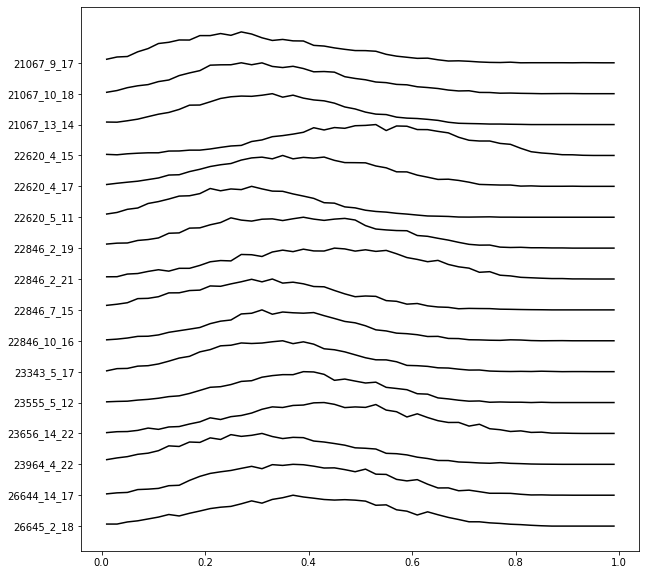

In [56]:
pearsons = []
scan_strs = []
for scan in nda.Scan():
    if scan['animal_id'] == 23964:
        scan.update({'group_id':163})
    scan_strs.append('_'.join([str(s) for s in [scan['animal_id'],scan['session'],scan['scan_idx']]]))
    pearsons.append((stats.Oracle.UnitScores & scan).fetch('pearson'))

bins = np.linspace(0,1,51)
bin_cents = np.mean(np.vstack((bins[:-1],bins[1:])),axis=0)
fig,ax = plt.subplots(figsize=(10,10))
for i,pearson in enumerate(pearsons):
    hist, _ = np.histogram(pearson,bins=bins)
    ax.plot(bin_cents,hist/np.max(hist)-i,c='k')
ax.set_yticks(0-np.arange(len(pearsons)))
_ = ax.set_yticklabels(scan_strs)
    
    

In [81]:
dj.U('n').aggr(dj.U('image_id').aggr((stimulus.Trial & nda.Scan)*stimulus.Frame,n='count(*)'),n_repeats='count(*)')

n calculated attribute,n_repeats calculated attribute
1,10000
2,10000
4,5000
6,5000
20,100
160,100


In [73]:
nda.Scan()

animal_id Animal ID,session Session ID,scan_idx Scan ID,nframes number of frames per scan,nfields number of fields per scan,fps frames per second (Hz)
21067,9,17,48252,10,7.97908
21067,10,18,49431,10,7.97908
21067,13,14,52671,10,7.97908
22620,4,15,49122,10,7.97908
22620,4,17,51593,10,7.97908
22620,5,11,48647,10,7.97908
22846,2,19,48050,10,7.97908
22846,2,21,55188,10,7.97908
22846,7,15,48123,10,7.97908
22846,10,16,48475,10,7.97908


In [72]:
stimulus.Trial & nda.Scan

animal_id id number,session session index for the mouse,scan_idx number of TIFF stack file,trial_idx trial index within sessions,condition_hash 120-bit hash (The first 20 chars of MD5 in base64),flip_times (s) row array of flip times,last_flip the last flip number in this trial,trial_ts automatic
21067,9,17,0,15mCD/4HR3GxTVTDkYQ9,=BLOB=,41208,2019-04-02 11:31:59
21067,9,17,1,XYVwxmW6T02K3lLYfOfo,=BLOB=,41211,2019-04-02 11:32:00
21067,9,17,2,AWiif6PEVm+pbAdcZ6D3,=BLOB=,41214,2019-04-02 11:32:01
21067,9,17,3,1oaqpMUh/XeFUgUF/bnm,=BLOB=,41217,2019-04-02 11:32:02
21067,9,17,4,7j7dCLy2vaDW5LHVKDH3,=BLOB=,41220,2019-04-02 11:32:03
21067,9,17,5,Y+MZTI06RrgkfbTeTtBY,=BLOB=,41223,2019-04-02 11:32:04
21067,9,17,6,SxvVSFo3tt/iaPEcKmyT,=BLOB=,41226,2019-04-02 11:32:05
21067,9,17,7,yczlG+uSMDSEGz7rW3cG,=BLOB=,41229,2019-04-02 11:32:06
21067,9,17,8,nyYrHGAeaUtkYVhkgITV,=BLOB=,41232,2019-04-02 11:32:07
21067,9,17,9,ZeII0QsMqDJA2z3iHJGz,=BLOB=,41235,2019-04-02 11:32:08


In [71]:
dj.U('n').aggr(dj.U('image_id').aggr(all_hashes*stimulus.Frame,n='count(*)'),n_repeats='count(*)')

n calculated attribute,n_repeats calculated attribute
1,25100
2,5000
7,100


In [68]:
stimulus.StaticImage.ImageNet()

image_class,image_id image id,imagenet_id id used in the actual imagenet dataset,description image content
imagenet,0,n02808304_8892,bath_towel
imagenet,1,n02909870_6487,bucket
imagenet,2,n03393912_4860,freight_car
imagenet,3,n03447447_4729,gondola
imagenet,4,n03445777_1976,golf_ball
imagenet,5,n03085013_22368,computer_keyboard
imagenet,6,n02493509_10615,titi
imagenet,7,n02033041_5332,dowitcher
imagenet,8,n02783161_6238,ballpoint
imagenet,9,n01820546_6799,lorikeet


In [67]:
stimulus.StaticImage()

image_class,frame_width pixels,frame_height pixels,num_channels number of channels in the image
blur_mei,256,144,1
blur_mei_act,256,144,1
blur_mei_thre,256,144,1
center_surround_color_excitatory,256,144,3
center_surround_color_inhibitory,256,144,3
center_surround_color_original,256,144,3
checkerboard,64,36,3
cnn_mei,256,144,1
color_decoding_contrast_adjusted_green,64,36,3
color_decoding_contrast_adjusted_noise,64,36,3


In [ ]:
repeat_rel = dj.U('image_class','image_id').aggr(stimulus.Frame & (stimulus.Trial & nda.Scan),n='count(*)')


In [ ]:
for scan in nda.Scan():
    scan_hashes = stimulus.

All stimulus conditions in the 14 scans are of the `stimulus.Frame` type.  30600 total unique stimulus conditions are shown.  The plot below can be used to identify scans that use each of the 6 different stimulus blocks.  However, 5000 condition hashes are the same image used twice with different pre-blank durations, corresponding to the second and third blocks from the left (haven't reconfirmed this).  100 condition hashes are the same image used seven times with different pre-blank durations, likely corresponding to the oracle clips.  The remaining 25000 conditions are unique.  Thus, there are actually 6 different stimulus sets represented in the 14 selected scans. 

stimulus_type class name of the special stimulus condition table class
stimulus.Frame


total stimulus conditions shown:  30600


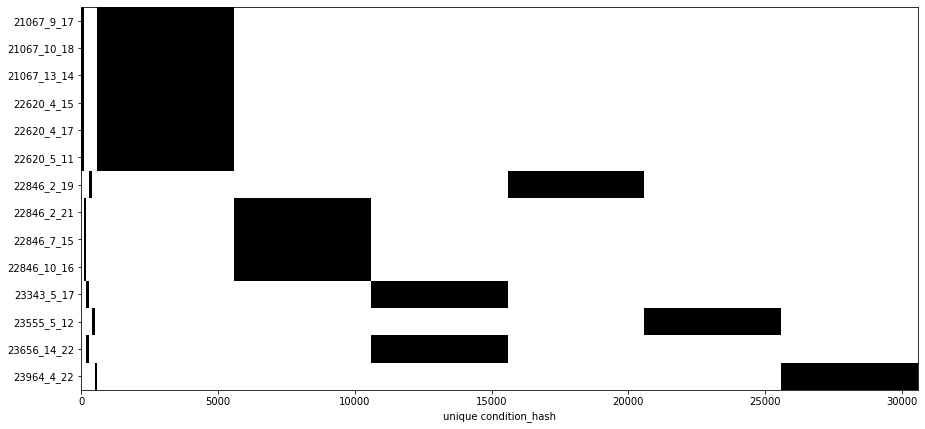

image_class,image_id image id,n calculated attribute
imagenet,0,1
imagenet,2,1
imagenet,4,1
imagenet,5,1
imagenet,7,1
imagenet,10,1
imagenet,13,1
imagenet,15,1
imagenet,16,1
imagenet,17,1


image_class,image_id image id,n calculated attribute
imagenet,16717,2
imagenet,16718,2
imagenet,16719,2
imagenet,16720,2
imagenet,16721,2
imagenet,16722,2
imagenet,16723,2
imagenet,16724,2
imagenet,16725,2
imagenet,16726,2


image_class,image_id image id,n calculated attribute
imagenet,104,6
imagenet,128,6
imagenet,183,6
imagenet,355,6
imagenet,479,6
imagenet,483,6
imagenet,656,6
imagenet,803,6
imagenet,830,6
imagenet,936,6


scans containing condition_hashes with non_unique images: 


animal_id Animal ID,session Session ID,scan_idx Scan ID
23964,4,22
22846,2,21
22846,7,15
22846,10,16


In [14]:
display(dj.U('stimulus_type') & ((stimulus.Trial & nda.Scan) * stimulus.Condition()))

all_hashes = dj.U('condition_hash','n_total','min_animal','min_scan','min_session') & dj.U('condition_hash').aggr(stimulus.Trial & nda.Scan,
                                                                            n_total='count(*)',
                                                                            min_animal='MIN(animal_id)',
                                                                            min_scan = 'MIN(scan_idx)', 
                                                                            min_session = 'MIN(session)')
print('total stimulus conditions shown: ', len(all_hashes))
hash_presence = []
for scan in nda.Scan():
    scan_hashes = (all_hashes.aggr(stimulus.Trial & scan,n_scan = 'count(trial_idx)',
                                   keep_all_rows=True)).fetch('n_scan',
                                   order_by='n_total DESC, min_animal ASC, min_scan ASC, min_session ASC')
    hash_presence.append({'scan_key':scan,'hash_presence':scan_hashes})
    
fig,ax = plt.subplots(figsize=(15,15))
ax.imshow(np.vstack([s['hash_presence'] for s in hash_presence])>0,cmap='binary',interpolation='none')
ax.set_aspect(1000)
ax.set_xlabel('unique condition_hash')
ax.set_yticks(np.arange(len(nda.Scan())))
_ = ax.set_yticklabels(['_'.join([str(s) for s in key.values()]) for key in nda.Scan.proj()])
plt.show()
plt.close()

repeat_rel = dj.U('image_class','image_id').aggr(stimulus.Frame & (stimulus.Trial & nda.Scan),n='count(*)')
no_repeat = repeat_rel & 'n=1'
display(no_repeat)
two_repeat = repeat_rel & 'n=2'
display(two_repeat)
seven_repeat = repeat_rel & 'n=6'
display(seven_repeat)

print('scans containing condition_hashes with non_unique images: ')
display(nda.Scan.proj() & (stimulus.Trial & (stimulus.Frame & two_repeat.proj())))

# Photodiode Collection and Alignment

# Two Photon Functional Imaging

In [14]:
total_durations = []
for scan in nda.ScanInclude():
    f1t = (nda.DepthTimes & scan).fetch1('field1_times')
    duration = f1t[-1] - f1t[0]
    n_traces = len(nda.Oracle() & scan)
    print(duration,n_traces,n_traces*duration)
    total_durations.append(n_traces*duration)

print('\n',np.sum(total_durations)/60/60)

6350.637286623 7493 47585325.18866614
6351.3603273749995 8592 54570887.93280599
6351.4113792732 8138 51687785.8045253
6350.4690897008 8158 51807126.83377913
6350.6923253334 8221 52209041.60656588
6350.84102434235 7971 50622553.80503287
6350.94900596755 7887 50089934.81006607
6350.8651231438 8618 54731755.631253265
6351.217085652251 11201 71139982.57639086
6351.45142599665 8194 52043792.98461655
6351.13351166755 9941 63136618.23948711
5804.40399374775 7973 46278513.04215081
5804.6378543529 7855 45595430.34594203
5926.5476758205 5130 30403189.576959167

 200528.31621617812


# Pre and post stimulus blanking

In [4]:
buffer_df = []
for scan in nda.Scan():
    dts = (nda.DepthTimes & scan).fetch1('depth_times')
    scan_start,scan_end = np.nanmin(dts),np.nanmax(dts)
    stim_start = (nda.Trial & scan).fetch('start_frame_time',order_by='start_frame_time ASC',limit=1)[0]
    stim_end = (nda.Trial & scan).fetch('end_frame_time',order_by = 'end_frame_time DESC',limit=1)[0]
    buffer_df.append({'session':scan['session'],
                      'scan_idx':scan['scan_idx'],
                      'scan_start':np.round(scan_start,2), 
                      'stim_start':np.round(stim_start,2),
                      'start_diff(s)':np.round(stim_start-scan_start,2),
                      'start_diff(m)':np.round((stim_start-scan_start)/60,2),
                      'scan_end':np.round(scan_end,2),
                      'stim_end':np.round(stim_end,2),
                      'end_diff(s)':np.round(scan_end-stim_end,2),
                      'end_diff(m)':np.round((scan_end-stim_end)/60,2)})
buffer_df = pd.DataFrame(buffer_df)  
print('pre-stimulus blanking: ', np.min(buffer_df['start_diff(m)']),'-',np.max(buffer_df['start_diff(m)']),' min')
print('post-stimulus blanking: ',np.min(buffer_df['end_diff(m)']),  '-',np.max(buffer_df['end_diff(m)']),' min')
display(buffer_df)
    

pre-stimulus blanking:  0.15 - 5.54  min
post-stimulus blanking:  8.26 - 21.2  min


,session,scan_idx,scan_start,stim_start,start_diff(s),start_diff(m),scan_end,stim_end,end_diff(s),end_diff(m)
0,4,7,0.0,8.70,8.70,0.15,6350.76,5079.04,1271.72,21.20
1,4,9,0.0,8.79,8.79,0.15,5574.90,5079.51,495.40,8.26
2,4,10,0.0,199.62,199.62,3.33,6351.17,5270.07,1081.09,18.02
3,5,3,0.0,332.37,332.37,5.54,6350.90,5402.55,948.35,15.81
4,5,6,0.0,196.25,196.25,3.27,6351.48,5266.75,1084.73,18.08
5,5,7,0.0,202.05,202.05,3.37,6351.53,5272.35,1079.18,17.99
6,6,2,0.0,290.48,290.48,4.84,6350.59,5362.61,987.98,16.47
7,6,4,0.0,194.02,194.02,3.23,6350.81,5264.70,1086.11,18.10
8,6,6,0.0,8.83,8.83,0.15,6350.96,5079.36,1271.60,21.19
9,6,7,0.0,222.33,222.33,3.71,6351.07,5292.94,1058.12,17.64


In [5]:
sync_df = []
for scan in list(nda.Scan()):
    behavior_path = (experiment.Session & {'animal_id':17797,**scan}).fetch1('behavior_path')
    local_path = lab.Paths().get_local_path(behavior_path)
    filename = (experiment.Scan.BehaviorFile() & {'animal_id':17797,**scan}).fetch1('filename')
    full_filename = os.path.join(local_path, filename)

    data = h5.read_behavior_file(full_filename)

    photodiode_times = h5.ts2sec(data['ts'], is_packeted=True)
    photodiode = data['syncPd']
    photodiode_freq = 1/np.nanmedian(np.diff(photodiode_times))
    
    trial_rel = (stimulus.Trial & {'animal_id':17797, **scan})
    first_trial_flip = trial_rel.fetch('flip_times',order_by='trial_idx ASC',limit=1)[0][0][0]
    last_trial_flip = trial_rel.fetch('flip_times',order_by='trial_idx DESC',limit=1)[0][0][-1]
    
    sync_trace,photodiode_start = (stimulus.Sync & {'animal_id':17797, **scan}).fetch1('frame_times','signal_start_time')
    if not(scan['session'] == 4 and scan['scan_idx'] == 9):
        sync_trace = sync_trace[0]
    sync_start,sync_end = sync_trace[0],sync_trace[-1]
    
    


    
    sync_df.append({'session':scan['session'],
                    'scan_idx':scan['scan_idx'],
                    'photodiode_times':photodiode_times,
                    'photodiode':photodiode,
                    'photodiode_freq':photodiode_freq,
                    'photodiode_start':photodiode_start,
                    'first_trial_flip':first_trial_flip,
                    'last_trial_flip':last_trial_flip,
                    'sync_trace':sync_trace,
                    'sync_start':sync_start,
                    'sync_end':sync_end})
sync_df = pd.DataFrame(sync_df)

# signal_start_times = []
# for _,r in sync_df.iterrows():
#     scan_key = {'animal_id':17797, **{v:r[v] for v in ['session','scan_idx']}}
#     signal_start_times.append((stimulus.Sync & scan_key).fetch1('signal_start_time'))
    

photodiode recording frequencies:  9999.95  -  10000.0  Hz


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:14: RuntimeWarning: invalid value encountered in less
  
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: invalid value encountered in greater
  app.launch_new_instance()


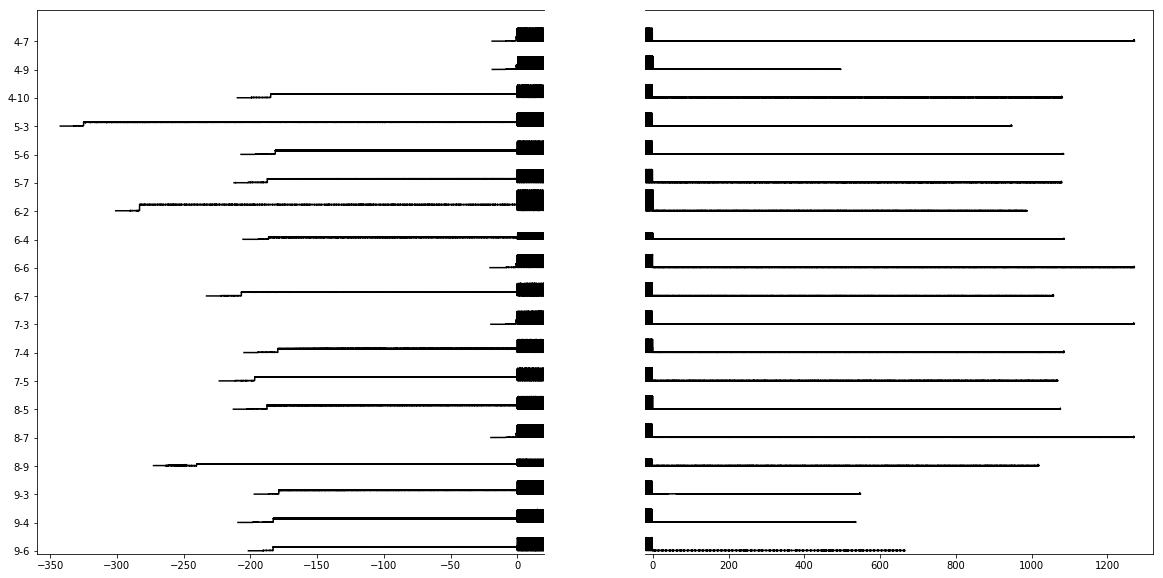

In [56]:
print('photodiode recording frequencies: ', np.round(np.min(sync_df['photodiode_freq']),2),' - ',
                                            np.round(np.max(sync_df['photodiode_freq']),2), ' Hz')

fig,axes = plt.subplots(1,2,figsize=(20,10))
# trace_buffer = 200000
plt_buffer = 200000
downsample_factor = 100


for i,r in sync_df.iterrows():
    photodiode_times = r['photodiode_times']
    photodiode = r['photodiode']
    stim_start_idx = np.max(np.where((photodiode_times-photodiode_times[0]) < 
                                     (r['first_trial_flip'] - r['signal_start_time'])))
    stim_end_idx = np.min(np.where((photodiode_times-photodiode_times[0]) > 
                                   (r['sync_end'] - r['last_trial_flip'])))
    axes[0].plot(photodiode_times[:stim_start_idx + trace_buffer:downsample_factor]-photodiode_times[stim_start_idx],
                 - i + photodiode[:stim_start_idx + plt_buffer:downsample_factor],'k')
    axes[0].set_xlim(-360,20)
    
    axes[1].plot(photodiode_times[-stim_end_idx-trace_buffer::downsample_factor]- photodiode_times[-stim_end_idx],   
                 -i + photodiode[-stim_end_idx-plt_buffer::downsample_factor] ,   'k')
    axes[1].set_xlim(-20,1320)

axes[0].set_ylim(-i-0.1,1.1)
axes[1].set_ylim(-i-0.1,1.1)
for ax in axes:
    ax.set_ylim(-i-0.1,1.1)

axes[0].set_yticks(-np.arange(len(sync_df)))
_ = axes[0].set_yticklabels(['-'.join([str(i),str(j)]) for i,j in zip(sync_df['session'],sync_df['scan_idx'])])

axes[1].set_yticks([])

axes[0].spines['right'].set_visible(False)
axes[1].spines['left'].set_visible(False)
